In [62]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [63]:
def potential(x):
    #2*x**2+3*torch.sin(torch.pi*x/2.4)*x*(1-torch.exp(-x/6))
    #x**3/20+torch.sin(torch.pi*x/10)*(20-x)*x+x**2/2
    #-10/x-8*(torch.sin(torch.pi*x/10))**2*torch.exp(-x/15)
    return -10/x

In [64]:
def energy(en_level,l,k,scale,device,dtype):
    en_list=[scale**2/(4*k*(i+1)**2) for i in range(en_level)]
    en_list=torch.tensor(en_list,device=device,dtype=dtype)
    return en_list

In [65]:
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mult=1
La=0
Lb =400
L=Lb-La  # domain length
N = 1999 # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)

# 控制势函数的大小
l_max=8
scale=10

en_num=50
epoch=200000
lr=0.01

diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap
V_diag=potential(grid)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())

In [75]:
print(diag.shape,diag.shape,off_diag.shape)
print(diag)
print(off_diag) 
print(V_diag.flatten())

torch.Size([1999]) torch.Size([1999]) torch.Size([1998])
tensor([25., 25., 25.,  ..., 25., 25., 25.], device='cuda:0')
tensor([-12.5000, -12.5000, -12.5000,  ..., -12.5000, -12.5000, -12.5000],
       device='cuda:0')
tensor([-5.0000e+01, -2.5000e+01, -1.6667e+01,  ..., -2.5038e-02,
        -2.5025e-02, -2.5013e-02], device='cuda:0')


In [66]:
eigenvalues= torch.linalg.eigvals(A)
eigenvalues = torch.real(eigenvalues)
eigenvalues,_=torch.sort(eigenvalues)
en=eigenvalues[:en_num]
print("Eigenvalues: \n",en)

Eigenvalues: 
 tensor([-3.0902e+01, -1.0356e+01, -5.0463e+00, -2.9508e+00, -1.9258e+00,
        -1.3523e+00, -1.0005e+00, -7.6943e-01, -6.0987e-01, -4.9507e-01,
        -4.0986e-01, -3.4484e-01, -2.9407e-01, -2.5381e-01, -2.2117e-01,
        -1.9457e-01, -1.7229e-01, -1.5385e-01, -1.3810e-01, -1.2467e-01,
        -1.1310e-01, -1.0302e-01, -9.4336e-02, -8.6604e-02, -7.9855e-02,
        -7.3867e-02, -6.8408e-02, -6.3711e-02, -5.9370e-02, -5.5451e-02,
        -5.1943e-02, -4.8744e-02, -4.5842e-02, -4.3179e-02, -4.0748e-02,
        -3.8518e-02, -3.6459e-02, -3.4567e-02, -3.2809e-02, -3.1188e-02,
        -2.9684e-02, -2.8283e-02, -2.6996e-02, -2.5683e-02, -2.4323e-02,
        -2.2834e-02, -2.1208e-02, -1.9451e-02, -1.7578e-02, -1.5603e-02],
       device='cuda:0')


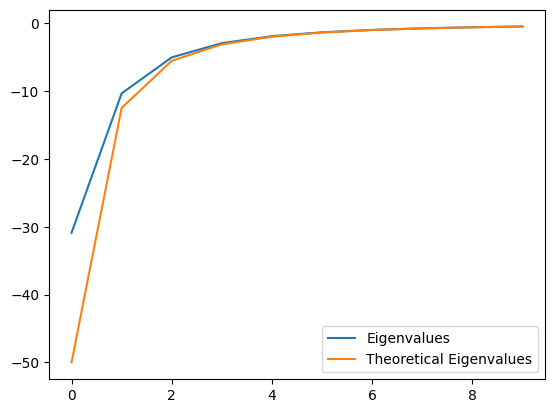

In [67]:
en_the=energy(en_num,l_max,b_lap,scale,device,dtype)
plt.plot(en[:10].cpu().numpy(),label='Eigenvalues')
plt.plot(en_the[:10].cpu().numpy(),label='Theoretical Eigenvalues')
plt.legend()
plt.show()

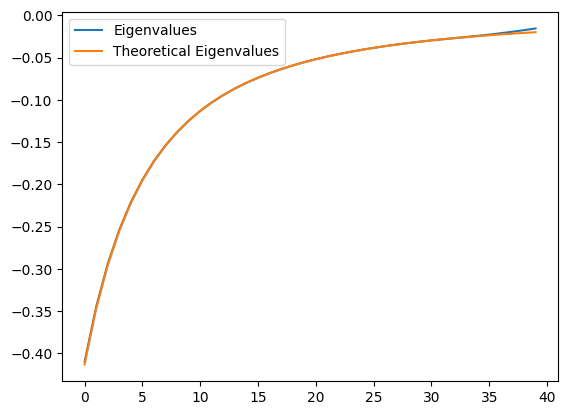

In [68]:
plt.plot(en[10:].cpu().numpy(),label='Eigenvalues')
plt.plot(en_the[10:].cpu().numpy(),label='Theoretical Eigenvalues')
plt.legend()
plt.show()

/tmp/ipykernel_1213899/1186928101.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


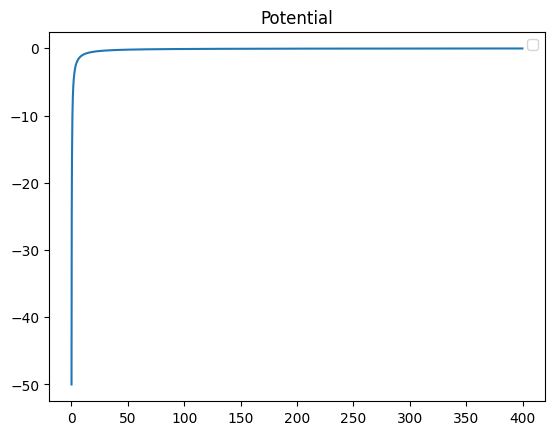

In [69]:
plt.plot(grid.cpu().numpy(),V_diag.cpu().numpy())
plt.title("Potential")
plt.legend()
plt.show()

In [70]:
eigs, eigv = torch.linalg.eig(A)

# print("Eigenvalues: \n", eigs[:en_num])
# print("Eigenvectors: \n", eigv[:,:en_num])

In [71]:
eigs = torch.real(eigs)
eigs_sorted, indices = torch.sort(eigs)
eigv_sorted = eigv[:, indices]

tensor(1., device='cuda:0')


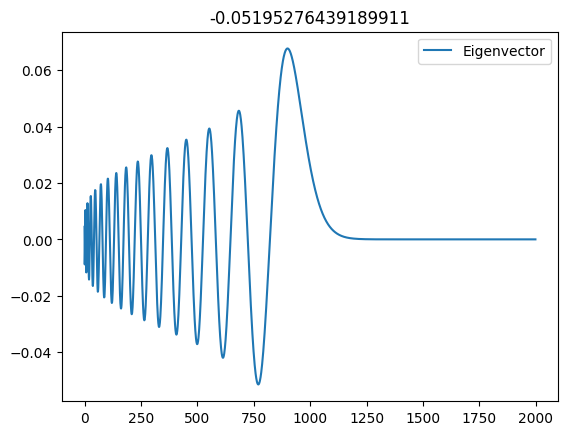

In [72]:
n=30
test_v=torch.real(eigv_sorted[:,n])
# test_vt=A@test_v
#归一化test_vt
# norm=torch.norm(test_vt)
# test_vt=test_vt/norm
print(torch.norm(test_v))
# norm=torch.norm(test_vt)
# print('normalization:',norm)

plt.plot(test_v.detach().cpu().numpy(),label="Eigenvector")
# plt.plot(test_vt.detach().cpu().numpy(),label="Eigenvector after applying A")
plt.title(f'{eigs_sorted[n]}')
plt.legend()
plt.show()

tensor(1., device='cuda:0')


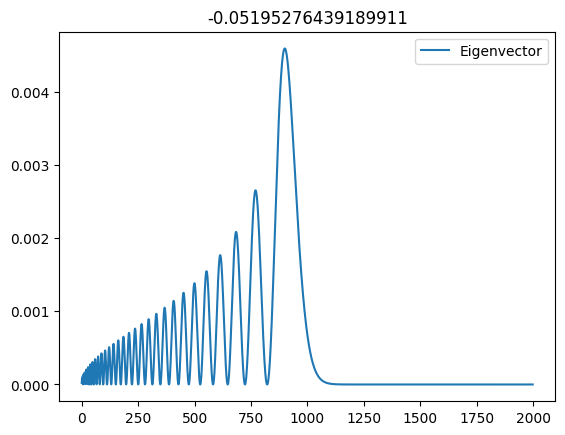

In [73]:
test_v=eigv_sorted[:,n]

# r=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
# R=r[1:-1]
# R=1/R 
# test_v=test_v*R

print(torch.norm(test_v))
test_v=test_v**2
#归一化test_vt
# norm=torch.norm(test_vt)
# test_vt=test_vt/norm



plt.plot(test_v.detach().cpu().numpy(),label="Eigenvector")
plt.title(f'{eigs_sorted[n]}')
plt.legend()
plt.show()